In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys
notebooks_path = os.path.abspath(".")  # Same folder as the notebook
src_path = os.path.abspath("../src")   # Your custom 'src' folder

for path in [notebooks_path, src_path]:
    if path not in sys.path:
        sys.path.append(path)




from ingest_data import DataIngestorFactory 
from data_inspector import DataInspector,DataTypesInspectionStrategy,SummaryStatisticsInspectionStrategy
from missing_values import SimpleMissingValuesAnalysis
from univariate_analysis import UnivariateAnalyzer , NumericalUnivariateAnalysis, CategoricalUnivariateAnalysis
from bivariate_analysis import BivariateAnalyzer, NumericalVsNumericalAnalysis , CategoricalVsNumericalAnalysis
from multivariate_analysis import SimpleMultivariateAnalysis





In [3]:
file_path = "C:\predicting_song_popularity\Data/archive (7).zip"

ingestor = DataIngestorFactory.get_ingestor(file_path)

df = ingestor.ingest(file_path)



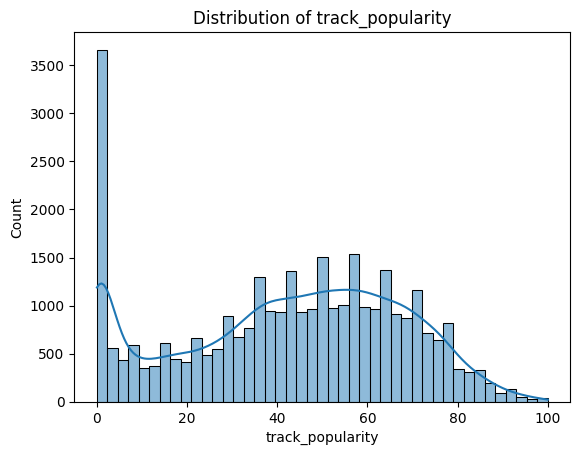

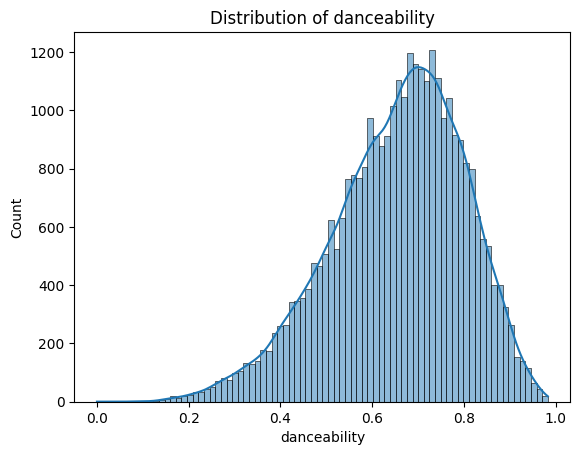

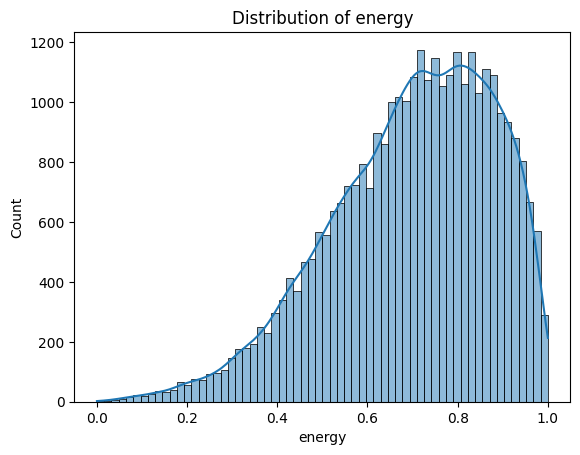

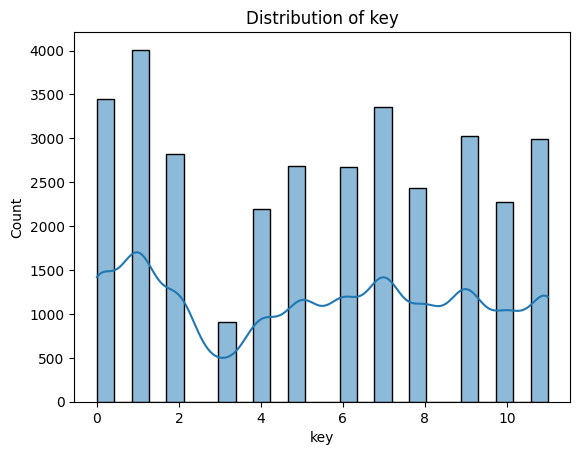

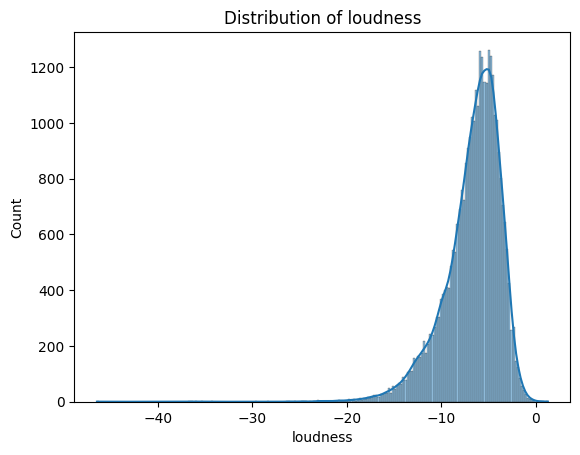

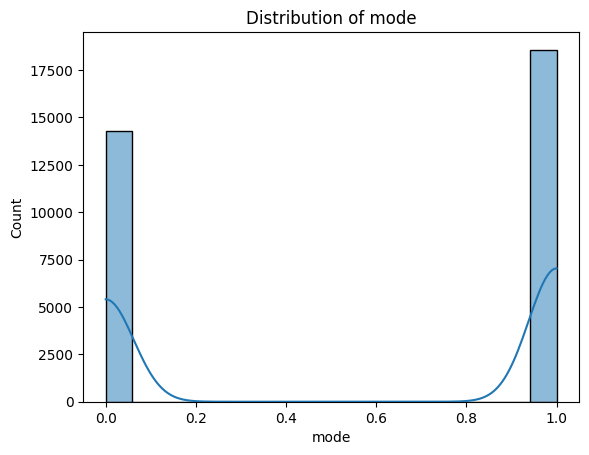

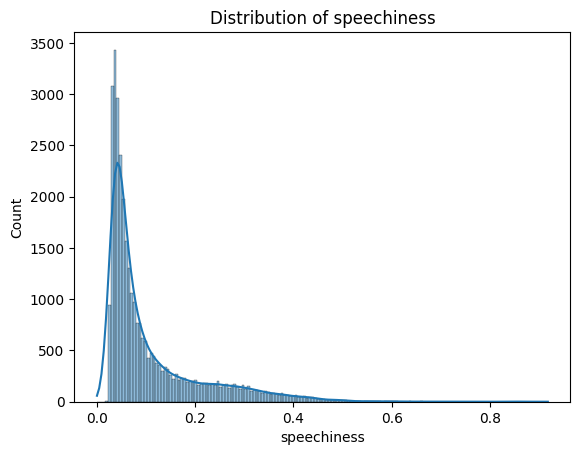

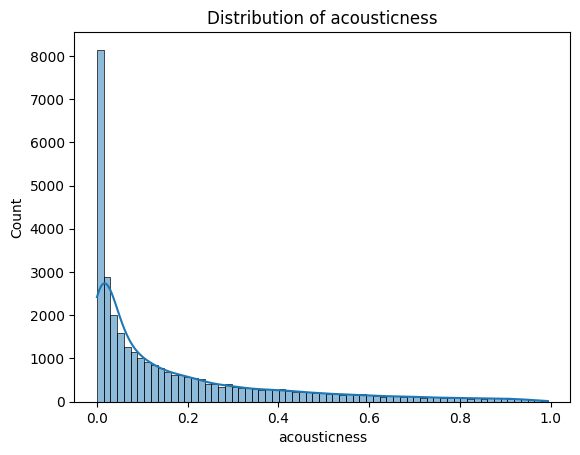

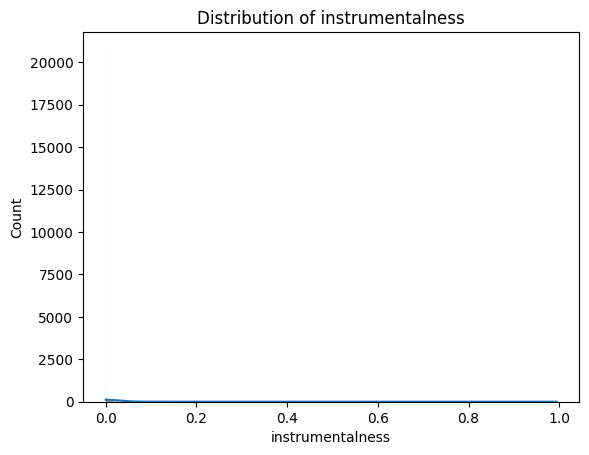

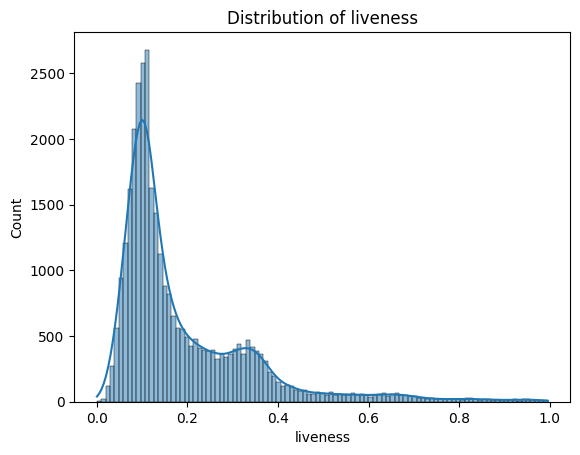

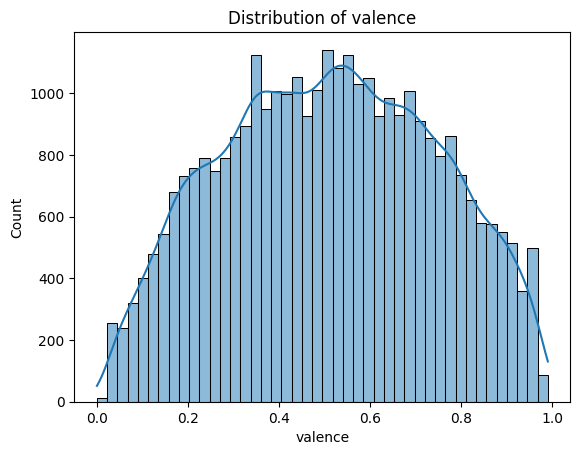

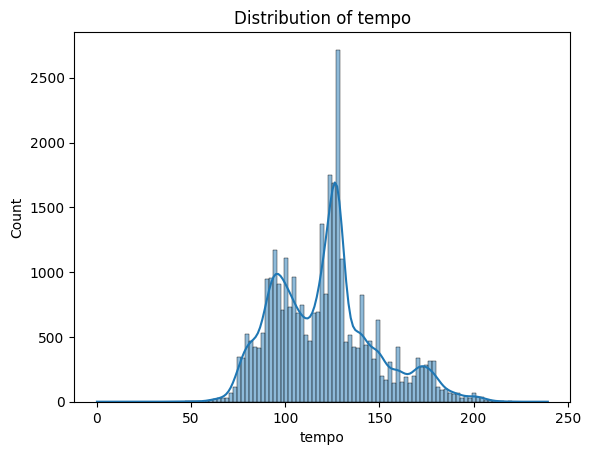

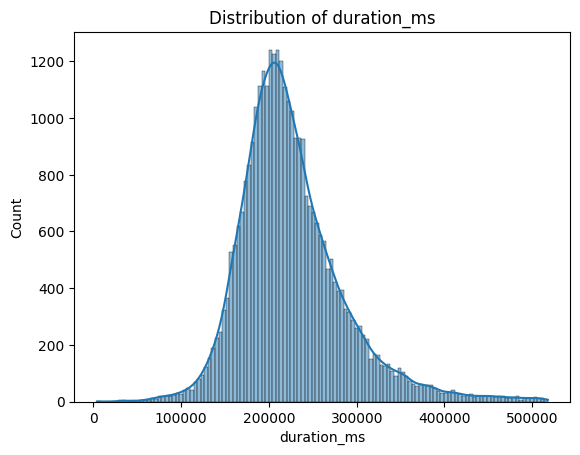

In [4]:


for col in df.select_dtypes(include='number').columns:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

In [5]:
skewed = df.select_dtypes(include='number').apply(lambda x: x.skew()).sort_values(ascending=False)
print(skewed)


instrumentalness    2.759472
liveness            2.076720
speechiness         1.967029
acousticness        1.594786
duration_ms         1.149863
tempo               0.528878
valence            -0.005485
key                -0.023909
track_popularity   -0.233320
mode               -0.265157
danceability       -0.504488
energy             -0.636330
loudness           -1.364097
dtype: float64


In [16]:
data_inspector = DataInspector(DataTypesInspectionStrategy())
data_inspector.execute_inspection(df)


Data Types and Non-null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32

In [19]:
data_inspector.set_strategy(SummaryStatisticsInspectionStrategy())
data_inspector.execute_inspection(df)


Summary Statistics (Numerical Features):
       track_popularity  danceability        energy           key  \
count      32833.000000  32833.000000  32833.000000  32833.000000   
mean          42.477081      0.654850      0.698619      5.374471   
std           24.984074      0.145085      0.180910      3.611657   
min            0.000000      0.000000      0.000175      0.000000   
25%           24.000000      0.563000      0.581000      2.000000   
50%           45.000000      0.672000      0.721000      6.000000   
75%           62.000000      0.761000      0.840000      9.000000   
max          100.000000      0.983000      1.000000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  32833.000000  32833.000000  32833.000000  32833.000000   
mean      -6.719499      0.565711      0.107068      0.175334   
std        2.988436      0.495671      0.101314      0.219633   
min      -46.448000      0.000000      0.000000      0.000000   
25%       -

Data Overview
Total observations: 32,833

Total features: 23

Feature types:

Numerical: 13 (including track_popularity, danceability, energy, etc.)

Categorical/Object: 10 (such as track_id, track_name, playlist_genre)

🧼 Data Quality Checks
Missing Values:

Minor missingness (~5 records) in:

track_name, track_artist, track_album_name

These are non-predictive identifiers in a regression context and can be safely dropped or imputed minimally if needed.

Duplicates:

track_id is not unique (10 repetitions of the top value), suggesting some tracks appear in multiple playlists or versions.

📊 Numerical Features
Target Variable: track_popularity

Range: 0 to 100

Distribution appears reasonably spread (mean ≈ 42.5, median ≈ 45), indicating potential for good variance in prediction.

Important Predictors:

danceability, energy, acousticness, valence, and tempo all have sufficient variance and complete data.

No features show obvious constant values or zero-variance, which is great for regression models.

Skewed Features (may need transformation):

instrumentalness, acousticness, and speechiness are heavily right-skewed (most values near 0).

Consider log or cube-root transformation if these are strong predictors.

🎼 Categorical Features
High cardinality in:

track_name, track_artist, track_album_name — likely not useful directly for regression unless encoded carefully (e.g., target encoding or embedding).

Low-cardinality useful categoricals:

playlist_genre (6 categories)

playlist_subgenre (24 categories)

These can be one-hot encoded or ordinal encoded, depending on modeling choices.



In [21]:
missing_values = SimpleMissingValuesAnalysis()
missing_values.identify_missing_values(df)


Missing Values Count by Column:
track_name          5
track_artist        5
track_album_name    5
dtype: int64


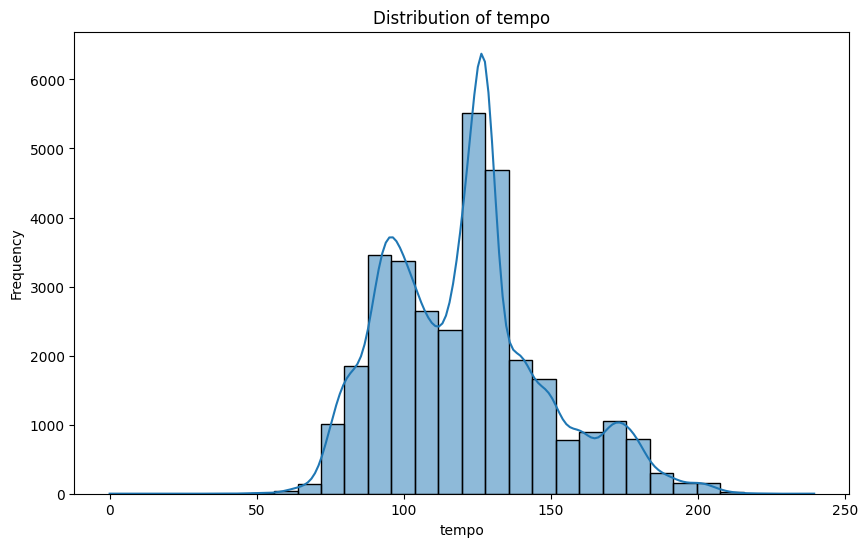

In [31]:
analyzer = UnivariateAnalyzer(NumericalUnivariateAnalysis())
analyzer.execute_analysis(df, 'tempo')



Distribution Insight: tempo
📊 Plot Summary
The tempo variable shows a multi-modal distribution, with two prominent peaks:

One around 95–100 BPM

Another sharp peak around 125–130 BPM

The spread ranges from ~0 to ~240 BPM, but the majority of songs cluster between 85 and 140 BPM, which is consistent with common popular music tempos.

Modeling Implications
tempo appears to have clear structure — it may strongly correlate with genre or subgenre, which in turn may impact track popularity.

Because it's numeric and fairly smooth, it’s ready for use in regression as-is. Binning is optional but might help for interpretability or classification tasks.

No transformation needed unless you're applying advanced techniques like Gaussian assumptions — this feature is in great shape.

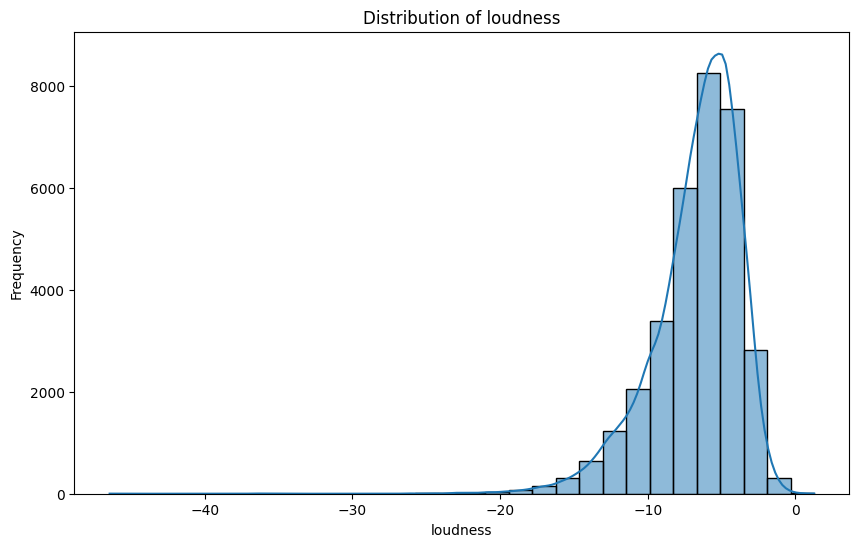

In [35]:
analyzer.set_strategy(NumericalUnivariateAnalysis())
analyzer.execute_analysis(df, 'loudness')

Distribution Insight: loudness
📊 Plot Summary
The loudness variable shows a left-skewed (negatively skewed) distribution, heavily concentrated between -12 dB and -3 dB.

There's a long left tail stretching down as far as -46 dB, but those extreme values are very rare.

A sharp mode exists around -5 to -6 dB, suggesting a standard "mastering sweet spot" for modern tracks.



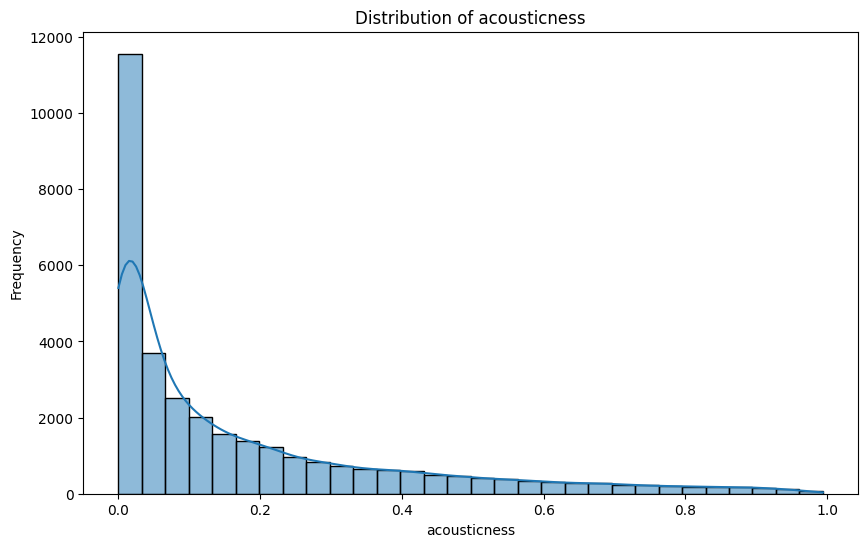

In [36]:
analyzer.set_strategy(NumericalUnivariateAnalysis())
analyzer.execute_analysis(df, 'acousticness')

Distribution Insight: acousticness
📊 Plot Summary
The distribution of acousticness is heavily right-skewed, with most values concentrated near 0.0.

A long tail stretches toward 1.0, but extremely acoustic tracks are rare.

A huge spike near zero indicates that the majority of songs are likely digitally produced or heavily mixed with little acoustic instrumentation.

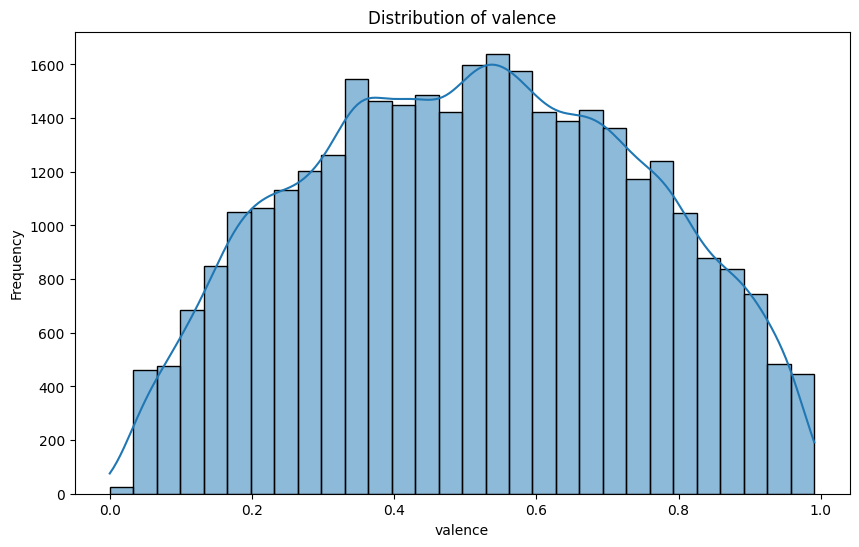

In [37]:
analyzer.set_strategy(NumericalUnivariateAnalysis())
analyzer.execute_analysis(df, 'valence')

Distribution Insight: valence
📊 Plot Summary
The valence variable, which measures the musical positivity or happiness of a track, displays a roughly symmetric, bell-shaped distribution.

Values span the full [0, 1] range, with a concentration around 0.5 to 0.6, suggesting many tracks exhibit moderate emotional positivity.

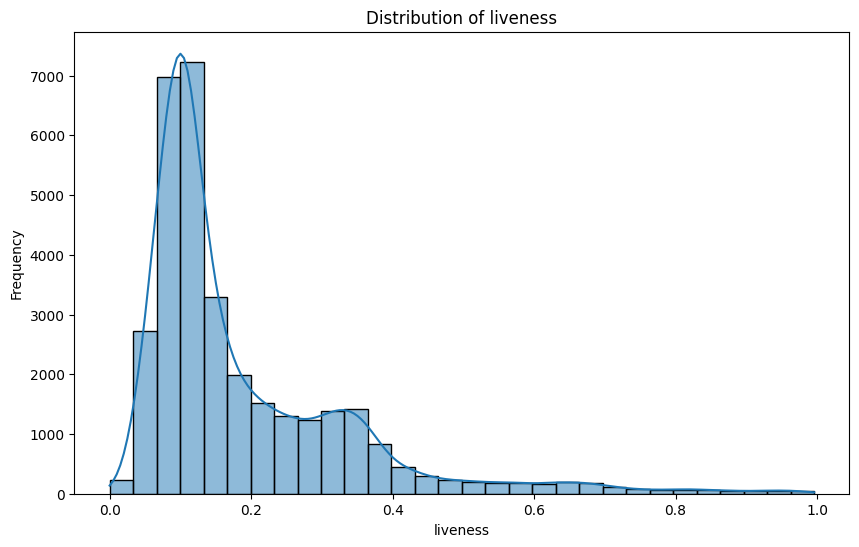

In [39]:
analyzer.set_strategy(NumericalUnivariateAnalysis())
analyzer.execute_analysis(df, 'liveness')

Distribution Insight: liveness
📊 Plot Summary
The liveness feature shows a strong right-skewed distribution, with the majority of values clustered between 0.05 and 0.2.

A long tail trails off toward 1.0, but values above 0.6 are rare.

The sharp spike around 0.1 indicates most tracks are likely studio recordings with minimal live ambience

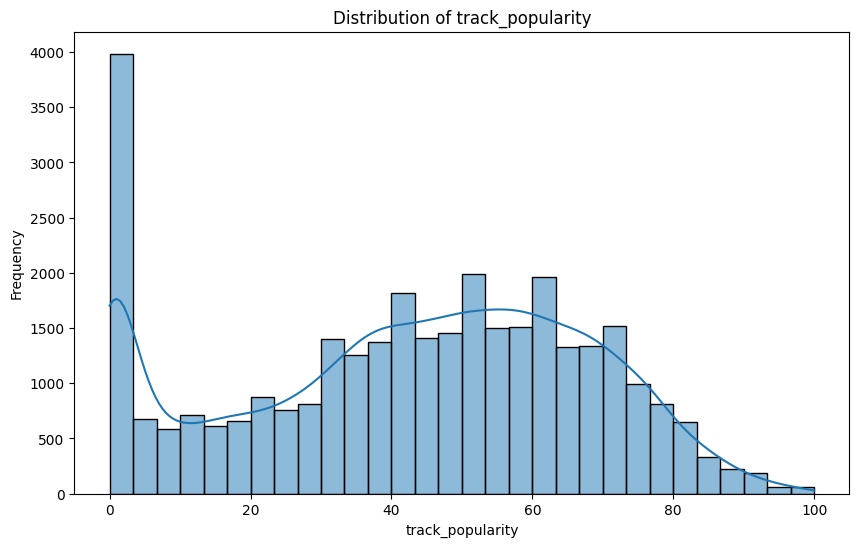

In [40]:
analyzer.set_strategy(NumericalUnivariateAnalysis())
analyzer.execute_analysis(df, 'track_popularity')

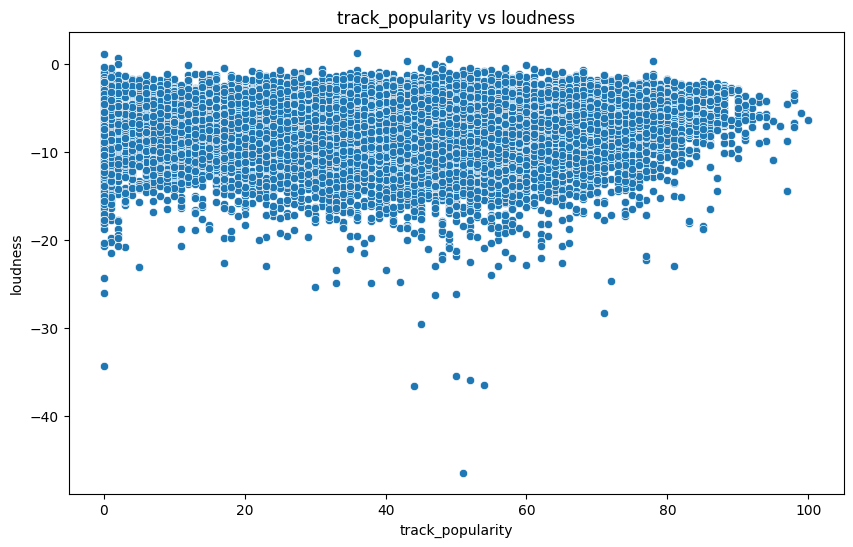

In [44]:
bivariate_analyzer = BivariateAnalyzer(NumericalVsNumericalAnalysis())
bivariate_analyzer.execute_analysis(df, 'track_popularity', 'loudness')

Interpretation
loudness appears to have a moderate positive relationship with track_popularity, but it's not linear or strongly correlated.

The spread at low popularity is wide, meaning low loudness alone doesn’t prevent popularity, but high popularity is rarely associated with very low loudness.

This makes sense in audio terms — louder tracks are often professionally mastered for impact and energy, contributing to streaming success.

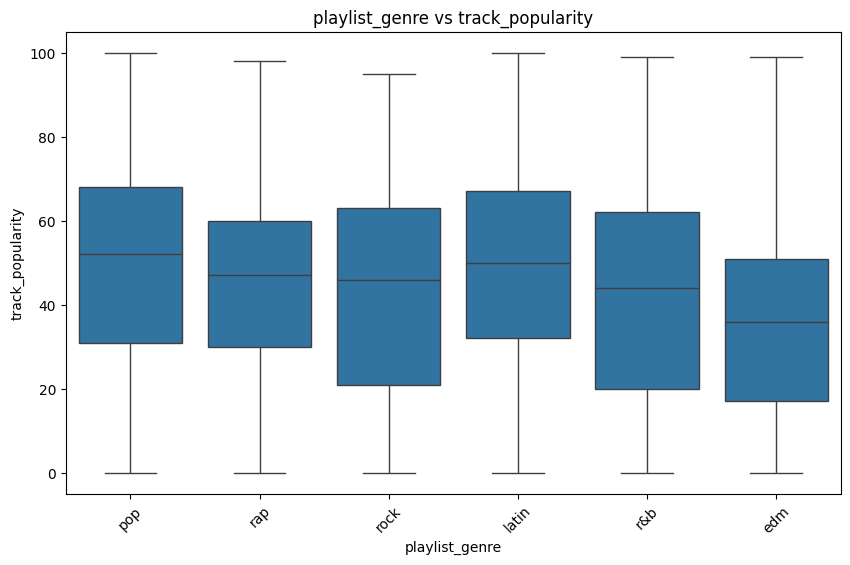

In [46]:
bivariate_analyzer = BivariateAnalyzer(CategoricalVsNumericalAnalysis())
bivariate_analyzer.execute_analysis(df, 'playlist_genre','track_popularity')

Boxplot Insight: track_popularity vs playlist_genre
📊 Plot Summary
This boxplot visualizes the distribution of track popularity across different playlist genres:

Each box shows the interquartile range (25th to 75th percentile)

The horizontal line is the median popularity

Whiskers show the range excluding outliers

🧠 Key Observations
Pop songs have a relatively high median popularity and a tight IQR, suggesting consistent mainstream appeal.

Rap and Latin genres also show strong median popularity, though with wider spreads — indicating both hits and misses.

EDM shows the lowest median popularity and a very compressed distribution — possibly reflecting niche playlisting or high production volume with fewer breakouts.

Rock and R&B have decent mid-level medians but broader variance.

🎯 Insights for Modeling
playlist_genre is a valuable categorical predictor — it explains a decent chunk of variance in track_popularity.

Consider one-hot encoding or target encoding this feature depending on your model type.

Genre may also interact with features like energy, tempo, or loudness — useful for tree-based models or interaction terms.



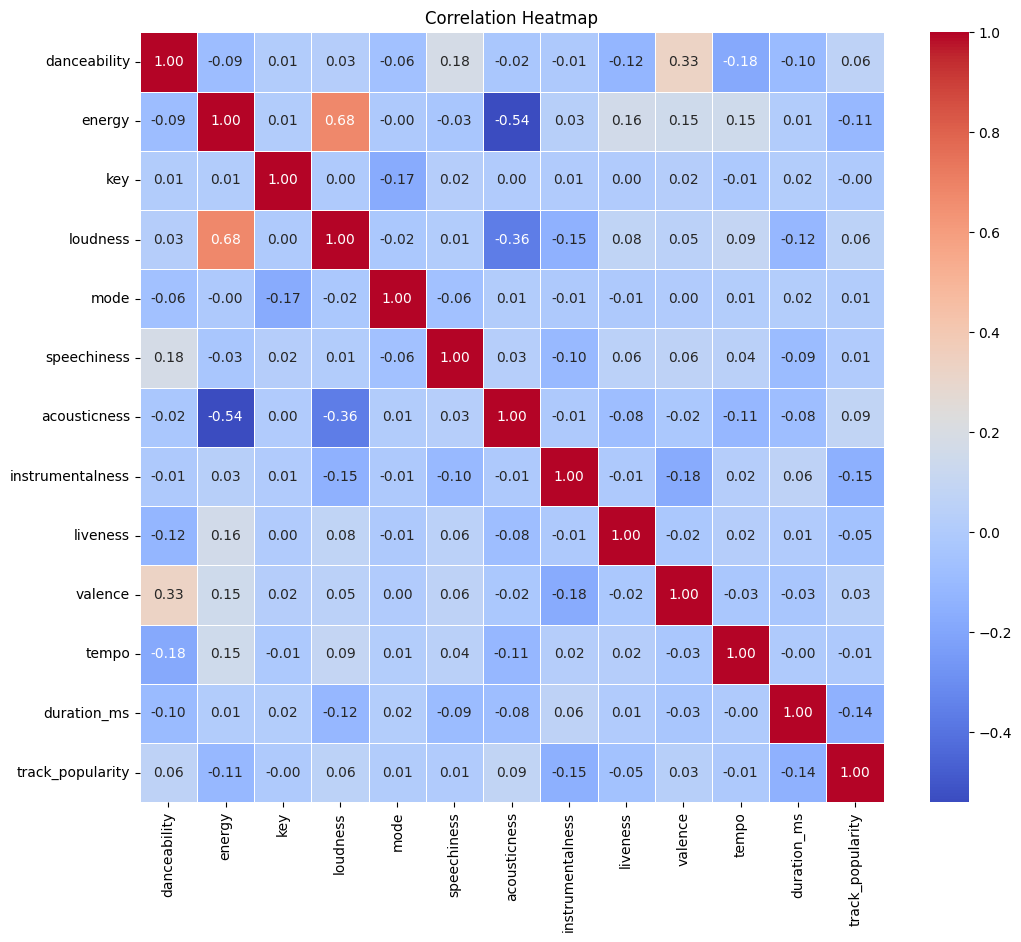

In [57]:
analyzer = SimpleMultivariateAnalysis()
numerical = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_popularity']]
analyzer.generate_correlation_heatmap(numerical)

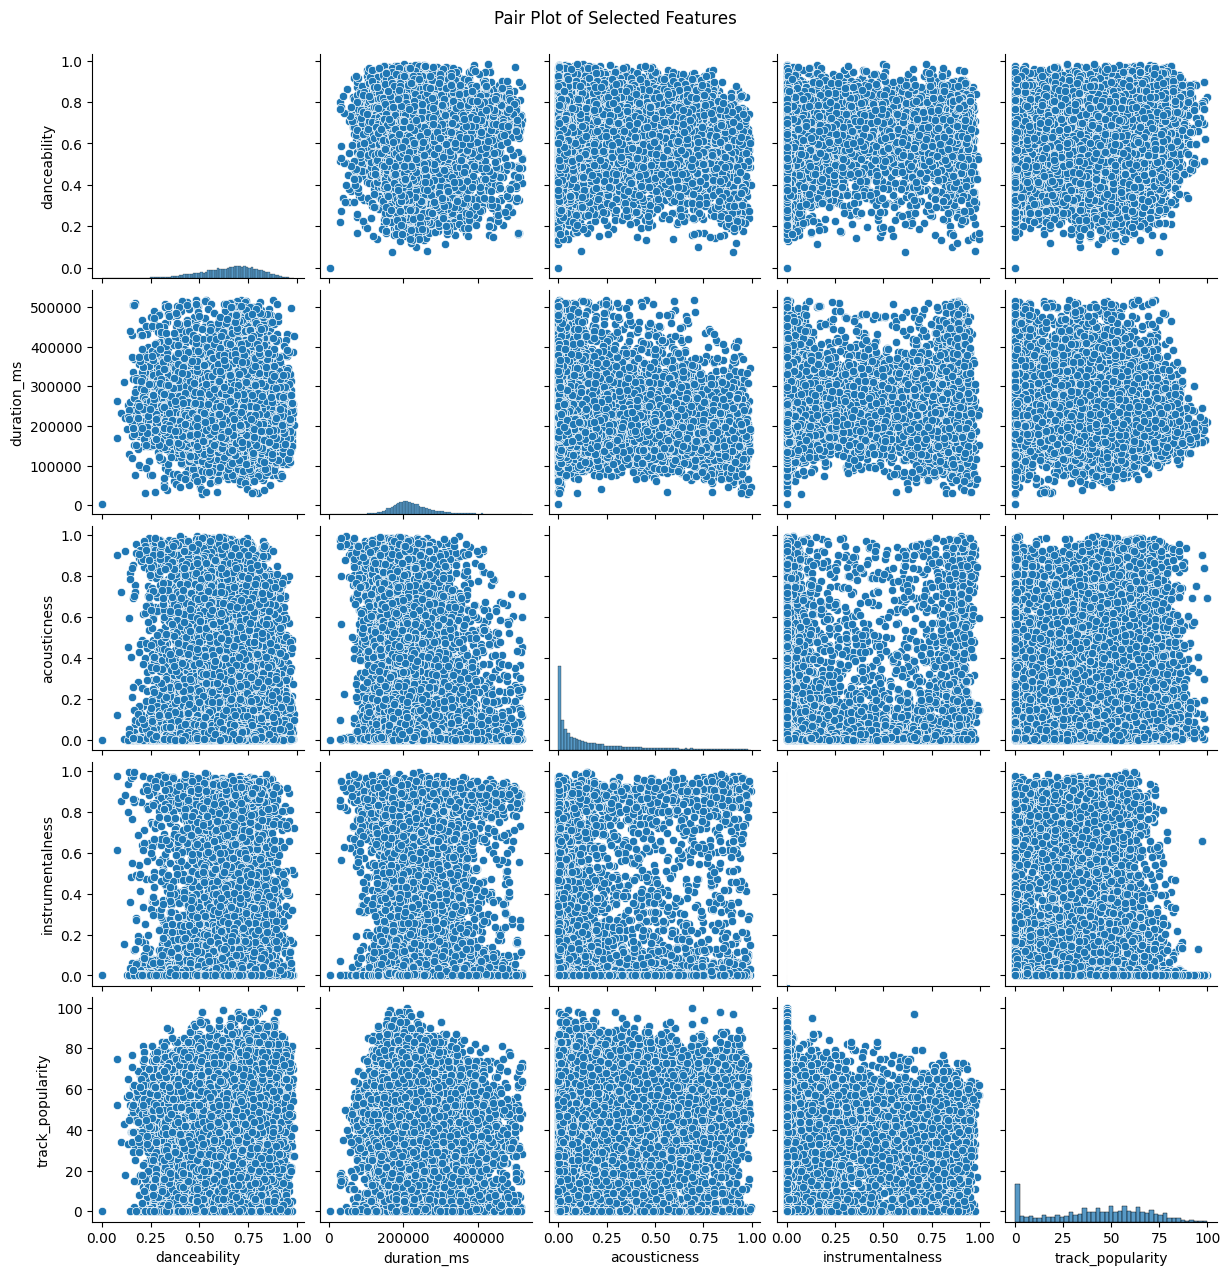

In [62]:
less = df[['danceability','duration_ms','acousticness','instrumentalness','track_popularity']]

analyzer.generate_pairplot(less)

In [63]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


NameError: name 'df' is not defined